<img src="https://www.strath.ac.uk/media/1newwebsite/webteam/logos/xUoS_Logo_Horizontal.png.pagespeed.ic.M6gv_BmDx1.png" width="350" align="left" style="left">

# 1. Spectral Analysis

## Introduction

Spectrum analysis is an important topic in signal processing, and particularly in wireless communications. We often look at signals in the frequency domain to analyze their properties or determine the type of signal we are dealing with. Radio spectrum a finite and expensive resource, which is often regulated by governmental bodies (e.g. Offcom in UK, or FCC across the pond in the USA). We use spectrum analysis tools frequently to observe the radio spectrum at various frequency bands, like Wi-Fi, Mobile stations, FM Radio, and many others. 

Some of the fundamental concepts for frequency domain analysis we will cover will be using the Discrete Fourier Transform (DFT) to go from time domain to frequency domain, technical tradeoffs that appear when we start considering spectral resolution and visualizing how frequency magnitude responses over time with waterfall plots (or spectrograms).

## Table of Contents

* [1.1 Discrete Fourier Transform](#dft)
* [1.2 Spectral Resolution and Leakage](#resolution)
* [1.3 Power Analysis](#power)
* [1.4 Waterfall Plots](#waterfall)
* [1.5 Conclusion](#conclusion)

This notebook will only require NumPy and Matplotlib libraries to run all the functions we require.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Discrete Fourier Transform <a class="anchor" id="dft"></a>

The fourier transform allows us to convert aperiodic time domain signals x[n] to the frequency domain representation X[f]. The DFT is a discrete version of this transform and is defined as

X[f] = $\sum_{n=0}^{N} x[n] e^{\frac{-j2\pi n}{f_s}}$

where N is the length of the signal, and $f_s$ is the sampling rate. It decomposes the signal 

**Fast Fourier Transform (FFT)**

What most engineers use in practice is the FFT algorithm, which is an efficient implementation of the DFT and is ubiquitous in most computing libraries, such as Numpy.

Let's start off by generating a simple signal in the time domain (a sine wave) and convert it to the frequency domain by applying an fft. We will generate a simple sine wave with a frequency of 256Hz, we oversample it by quite a bit with a sampling rate of 2048Hz - this is for plotting reasons.

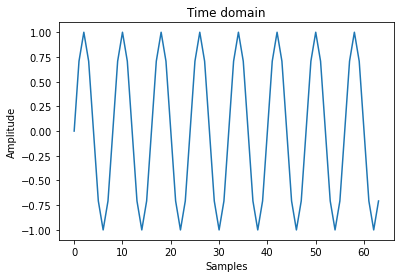

In [2]:
# Set basic params
fs = 2048 # sample rate
f = 256 # frequency of signal

# Create a sampled sinusoid 
sine = np.sin(2*np.pi*f*np.arange(512)/fs)

# Plot it
plt.plot(sine[:64])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Time domain')
plt.show()

Now we can transform our signal to the frequency domain by using the FFT. We can use the NumPy FFT implementation by calling the FFT function from the NumPy FFT library, which can take the FFT size as an argument. We usually pick a size for FFT as a power of two ($2^{N}$) due to optimizations in the algorithm - in this case we choose 512. In case our FFT size is larger than the provided signal, typically implementations like the one in Numpy will pad our input with zeros until it reaches the closest power of 2 value.

Additionally Numpy makes life a bit easier for us, and provides some utility functions like **fftfreq** and **fftshift**, so we do not have to manually compute the frequencies of each FFT bin, and we do not have to rearrange the positive and negative frequency components to visualize the output in a more intuitive way (if we were to plot the fft output directly, we would see the positive frequencies on the negative axis and negative frequencies on the positive axis).

In [3]:
# Set fft size
N_fft = 512 

# Calculate fft
sine_fft = np.fft.fft(sine, N_fft)

# Get the corresponding frequencies, that depend on N_fft and Fs
freqs = np.fft.fftshift(np.fft.fftfreq(N_fft,1/fs))

# Shift fft so it aligns with the frequencies
sine_fft = np.fft.fftshift(sine_fft)

Note that we are not plotting the FFT result directly, but actually taking the absolute value of it. This is due to the fact that the FFT output is complex.

After plotting the FFT of our 250Hz sine wave we will see two mirroring spikes at +250Hz and -250Hz. This is because our signal was purely real (as opposed to complex), and as such will always produce a symmetrical FFT output on both the positive and "negative" frequencies (we are using quotes here because in reality there is no such thing as a negative frequency, practically speaking this shows us that this part of the FFT output is lower relative to the carrier frequency).

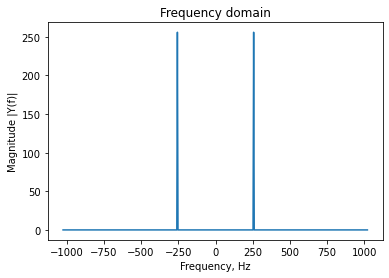

In [4]:
plt.plot(freqs, np.abs(sine_fft))
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude |Y(f)|')
plt.title('Frequency domain')
plt.show()

If we were dealing, for example, with a sound waveform we would just disregard the negative frequencies and look at the relevant positive band. This is only true when dealing with real data, if our signal is composed of complex samples, as most wireless signals are, we would likely see an assymetrical result.

**FFT on Complex Data**

It is more common to deal with complex signals (such as modulated waveforms in a communications system), which would appear on our FFT plot on the frequency bins they were captured on, with no mirror images. We can demonstrate this by creating a complex sine wave - a periodic signal made up for two sine waves, 90 degrees out of phase.

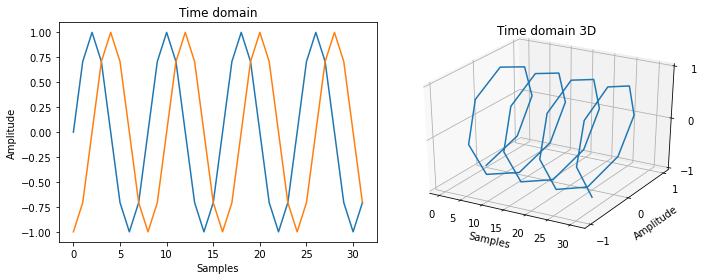

In [5]:
# create a complex signal of the same frequency as our last sine
complex_sine = np.sin(2*np.pi*f*np.arange(512)/fs) - 1j*np.cos(2*np.pi*f*np.arange(512)/fs)

fig = plt.figure(figsize=(10,4))

# Plot real and imaginary channels
axes = fig.add_subplot(1,2,1)
axes.plot(complex_sine.real[:32])
axes.plot(complex_sine.imag[:32])
axes.set_xlabel('Samples')
axes.set_ylabel('Amplitude')
axes.set_title('Time domain')

# Plot complex sine wave in 3d plane
axes = fig.add_subplot(1,2,2, projection='3d')
axes.plot(np.arange(32), complex_sine.real[:32], complex_sine.imag[:32])
axes.set_yticks([-1,0,1])
axes.set_zticks([-1,0,1])
axes.set_xlabel('Samples')
axes.set_ylabel('Amplitude')
axes.set_ylabel('Amplitude')
axes.set_title('Time domain 3D')
fig.tight_layout()

Now after taking the FFT of our new, complex signal, we will see only a single peak as one would intuitively expect.

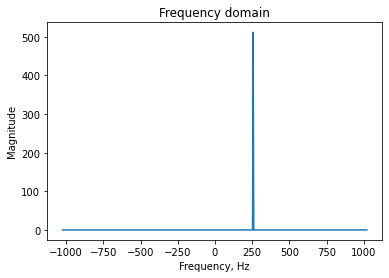

In [6]:
# calculate fft
sine_fft = np.fft.fftshift(np.fft.fft(complex_sine, N_fft))
freqs = np.fft.fftshift(np.fft.fftfreq(N_fft,1/fs))

plt.plot(freqs, np.abs(sine_fft))
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Frequency domain')
plt.show()

**Sum of Tones**

The DFT is not only used for checking out single tones, most signals can be decomposed into sine waves and we can use frequency analysis to separate the individual components making up a signal. Below we create an arbitrary signal by summing a few sine waves of different frequencies and amplitudes. While the components making up the signal would be quite difficult to distinguish by eye, transforming the signal to the frequency domain can give a lot of insight on its properties.

In [7]:
# Set basic params
fs = 1024 # sample rate
f1 = 64 # frequency of first signal
f2 = 128 # frequency of 2nd signal
f3 = 256 # frequency of 3rd signal
N_fft = 512 # fft size

# create a sampled sinusoid and corresponding frequencies for plotting
sine_1 = np.sin(2*np.pi*f1*np.arange(2048)/fs)
sine_2 = 0.5*np.sin(2*np.pi*f2*np.arange(2048)/fs)
sine_3 = 0.7*np.sin(2*np.pi*f3*np.arange(2048)/fs)

sum_of_tones = sine_1 + sine_2 + sine_3

fft_result = np.fft.fft(sum_of_tones, N_fft)
freqs = np.fft.fftfreq(N_fft,1/fs)

Applying an FFT to our signal, we can clearly see that it is composed of 3 distinct sinusoids of different energy. Sine waves that have a higher amplitude will end up having more energy that pours into its corresponding frequency bin.

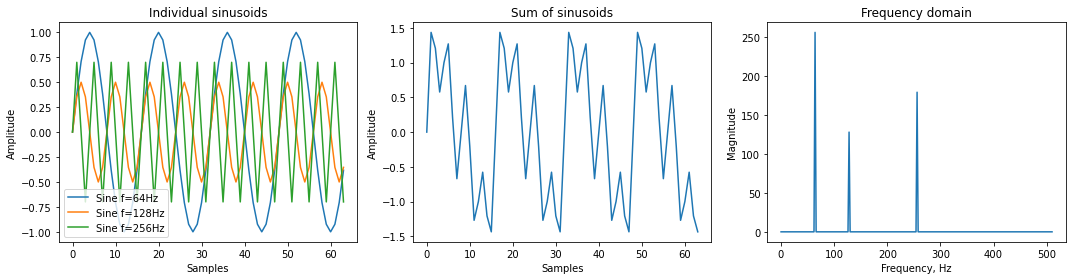

In [8]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].plot(sine_1[:64])
axs[0].plot(sine_2[:64])
axs[0].plot(sine_3[:64])
axs[0].set_title('Individual sinusoids')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')
axs[0].legend(('Sine f=64Hz', 'Sine f=128Hz', 'Sine f=256Hz'))

axs[1].plot(sum_of_tones[:64])
axs[1].set_title('Sum of sinusoids')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Amplitude')

axs[2].plot(freqs[:int(N_fft/2)], np.abs(fft_result[:int(N_fft/2)]))
axs[2].set_title('Frequency domain')
axs[2].set_ylabel('Magnitude')
axs[2].set_xlabel('Frequency, Hz')
fig.tight_layout()

## Spectral Resolution and Leakage <a class="anchor" id="resolution"></a>

In the previous examples we specifically selected frequencies that fall perfectly onto our FFT bins (for our FFT size) and produced 3 beautiful clean spikes. In practice an observed frequency very rarely falls directly into a bin, as we are limited in the number of exact frequencies we can represent by the *spectral resolution*, defined as 

$\Delta{f} = \frac{f_{s}}{N}$

where $f_{s}$ is our sampling rate and $N$ is the number of FFT bins (or FFT size). Bigger FFT sizes allow for more frequencies being correctly resolved, however this comes at the cost of more complexity, as computing large FFTs is more expensive.

We can visualize this by generating sine wave of frequency that doesn't fall exactly on our FFT bin (i.e. frequency isn't a power of 2 value like 64, 128, 256, etc.). Let's see what a frequency of 250Hz would look like. We will only look at the positive side of the spectrum.

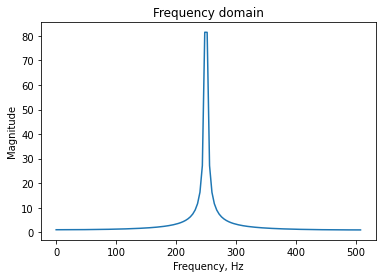

In [9]:
# Set sample rate and sine frequency
fs = 1024
f = 250

# Set FFT size
N_fft = 256

# Set sine wave length
L = 256

# Create a sampled sinusoid
sine = np.sin(2*np.pi*f*np.arange(L)/fs)

# Compute fft and corresponding frequencies, since our signal is real we only 
# look at half the output (positive frequencies)
fft_result = np.abs(np.fft.fft(sine, N_fft)[:int(N_fft/2)])
freqs = np.fft.fftfreq(N_fft,1/fs)[:int(N_fft/2)]

# Plot the FFT results
plt.plot(freqs, fft_result)
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Frequency domain')
plt.show()

Note that now the peak is not as clear-cut as the previous examples, the energy of the signal is spread to neighbouring FFT bins. Furthermore if we print out the actual peak frequency, according to our FFT it is 248Hz! Yet we clearly set it to 250hz. 

In [10]:
print('Frequency resolution = {} Hz'.format(fs/N_fft))
print('Peak frequency {}Hz (FFT size = {})'.format(freqs[np.argmax(fft_result)], N_fft))

Frequency resolution = 4.0 Hz
Peak frequency 248.0Hz (FFT size = 256)


As mentioned earlier, an easy way to improve the precision of our frequency domain representation is to increase the spectral resolution by using more FFT bins. If we increase N_fft to a larger value of 512 we will double our spectral resolution, resulting in a sharper spike. Ideally we should also double the number of samples of our input signal, otherwise we could end up dealing with spectral leakage as demonstrated below.

Text(0.5, 1.0, 'Same FFT size as signal')

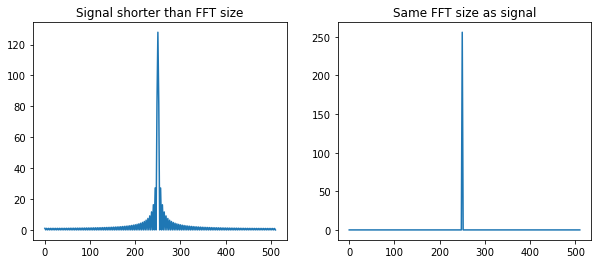

In [11]:
# Set sample rate and sine frequency
fs = 1024
f = 250

# Set FFT size
N_fft = 512

# Set sine wave lengths
L1 = 256
L2 = 512

# Create two sine waves of different durations
sine1 = np.sin(2*np.pi*f*np.arange(L1)/fs)
sine2 = np.sin(2*np.pi*f*np.arange(L2)/fs)

# Calculate the fft and frequencies of the 1st sine wave
fft_sine1 = np.abs(np.fft.fft(sine1, N_fft)[:int(N_fft/2)])
freqs1 = np.fft.fftfreq(N_fft,1/fs)[:int(N_fft/2)]

# Calculate the fft and frequencies of the 2nd sine wave
fft_sine2 = np.abs(np.fft.fft(sine2, N_fft)[:int(N_fft/2)])
freqs2 = np.fft.fftfreq(N_fft,1/fs)[:int(N_fft/2)]

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(freqs1, fft_sine1)
ax[0].set_title('Signal shorter than FFT size')
ax[1].plot(freqs2, fft_sine2)
ax[1].set_title('Same FFT size as signal')

If we provide a signal to the FFT algorithm implemented in NumPy that is shorter than the FFT size, it will be padded with zeros until it matches. Sharp transitions in the time domain, such as a signal abruptly dropping to zero, translate into the frequency domain as distributions over many frequency bins, causing spectral leakage as seen in the left figure. It is usually a good idea to set your input length to match the FFT size you are using.

Printing out the peak values, we can see that the resolution is fine enough for both to produce the max frequency we were after at 250Hz! Increasing FFT size without adding more samples to the input can still have the desired effect of spectral resolution, however we may end up dealing with the side effect of spectral leakage.

In [12]:
print('Frequency resolution = {} Hz'.format(fs/N_fft))
print('Peak frequency {}Hz (Signal length = {}, FFT size = {})'.format(freqs[np.argmax(fft_sine1)], L1, N_fft))
print('Peak frequency {}Hz (Signal length = {}, FFT size = {})'.format(freqs[np.argmax(fft_sine2)], L2, N_fft))

Frequency resolution = 2.0 Hz
Peak frequency 500.0Hz (Signal length = 256, FFT size = 512)
Peak frequency 500.0Hz (Signal length = 512, FFT size = 512)


**Windowing**

The DFT assumes that the input signal is periodic and the capture is representative of the true period of the signal (meaning that the last sample should "connect" to the first sample). However in reality we are often dealing with aperiodic signals and the start and end sample transitions are rarely smooth. These abrupt discontinuities cause spectral leakage in the frequency domain.

To reduce the effect of spectral leakage we can apply a window to a signal. Windowing “squashes” our signal at the ends, so that transitions seem smoother. The downside of using this method is that the main lobe (the frequency peak) gets a bit wider and we lose some spectral resolution - as most things it is a tradeoff. Technically all the previous examples have already been using windowing - the rectangular window - which is simply every value of the signal multiplied by 1 (not changing the signal). 

Numpy has built-in windowing functions ready to go. Some popular options are Hanning, Blackman, Bartlett and Hamming windows as shown below.

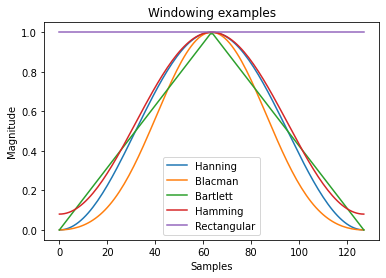

In [13]:
window_length = 128

plt.plot(np.hanning(window_length))
plt.plot(np.blackman(window_length))
plt.plot(np.bartlett(window_length))
plt.plot(np.hamming(window_length))
plt.plot(np.ones((window_length,1)))
plt.legend(('Hanning', 'Blacman', 'Bartlett', 'Hamming', 'Rectangular'))
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.title('Windowing examples')
plt.show()

Let's generate another sine wave, and visualize what applying a Hamming window does to it.

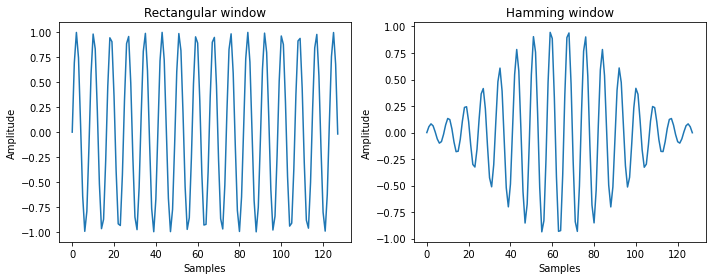

In [14]:
# Generate sine wave
fs = 2048
sine = np.sin(2*np.pi*250*np.arange(128)/fs)

# Apply window
windowed_sine = sine*np.hamming(128)

fig, axes = plt.subplots(1,2, figsize=(10,4))

# Plot sine wave
axes[0].plot(sine)
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Rectangular window')
# Plot windowed sine wave
axes[1].plot(windowed_sine)
# axes[1].plot(np.hamming(128))
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Hamming window')
fig.tight_layout()

Now we can take the FFT of both, the original and windowed sinusoids, to compare the outputs. We will only be looking at the positive frequencies.

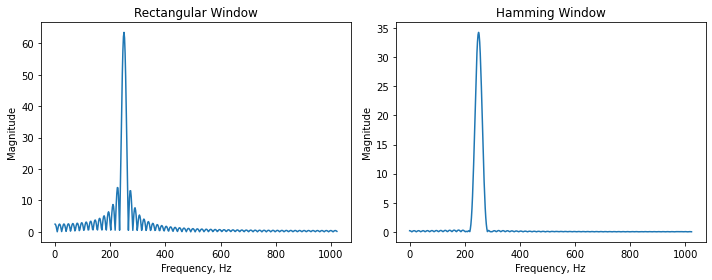

In [15]:
# Calculate the FFT of the original and windowed sine
N_fft = 1024 # increased fft size for exaggerated leakage
fft_result = np.fft.fft(sine, N_fft)[:int(N_fft/2)]
fft_result_windowed = np.fft.fft(windowed_sine, N_fft)[:int(N_fft/2)]

# Get corresponding frequencies
freqs = np.fft.fftfreq(N_fft,1/fs)[:int(N_fft/2)]

fig, axes = plt.subplots(1,2, figsize=(10,4))

# Plot sine wave
axes[0].plot(freqs, np.abs(fft_result)) # plotting half for better visualization
axes[0].set_xlabel('Frequency, Hz')
axes[0].set_ylabel('Magnitude')
axes[0].set_title('Rectangular Window')

# Plot windowed sine wave
axes[1].plot(freqs, np.abs(fft_result_windowed))
axes[1].set_xlabel('Frequency, Hz')
axes[1].set_ylabel('Magnitude')
axes[1].set_title('Hamming Window')
fig.tight_layout()
plt.show()

Note how applying the Hamming window made the main lobe of our signal wider, but reduced all the sidelobes in the surrounding FFT bins.

## Power Analysis <a class="anchor" id="power"></a>

So far we have been using the FFT and exploring different frequency components on a linear scale. In signal processing and wireless communications we normally deal with power spectrum where the measurements are represented in decibels (dB). Generally all this means is that we re-scale our FFT results onto a logarithmic scale, this is useful as oftentimes the signal of interest can be many times greater than the noise floor and it would be very difficult to visualize otherwise.

**Note on Decibels**

The decibel (dB) is a measure of power in relation to some unit - in wireless comms we often use dBW which means the power is relative to 1 Watt, more commonly dBm is used corresponding to 1 milliwatt (mW), as the energy usually transmitted, by say a phone, over the air is very tiny. Here's a quick reference to some common dB terms you may encounter in spectral analysis:

| Term | Description |
| --- | --- | 
| dB | Decibel |
| dBW | Decibel relative to 1 Watt |
| dBm or dBmW | Decibel relative to 1 milliwatt |
| dB/Hz | Decibel per hertz, used when measuring Power Spectral Density |
| dBFS | Decibel Full Scale - assumes that a full-scale sine wave is designated 0 dB FS |
| dBc | Decibel relative to carrier - how many dBs is a signal below the carrier power |
| dBc/Hz | dBc in 1-Hz bandwidth - used to make noise floor measurements |

There are other possible variations, just be aware that usually it is just a matter of scaling.

**Power Spectral Density**

One of the most common ways of observing the power spectra of a signal of interest is by calculating the Power Spectral Density (PSD), defined as

$PSD[n] = 10 \times \log_{10}(\frac{2 {|y[n]|^{2}}}{F_{s} \sum^{N_{w}}_{n=0}w^{2}[n]})$

We get the power of the signal by squaring the absolute values of the FFT output $y[n]$, and normalize by the sampling rate $F_{s}$ and the sum of our window weights $w$, where $N_{w}$ is the length of our window. Don't forget to add a factor of 2 since we are dealing with a one-sided spectrum. The PSD is measured in decibels per hertz (dB/Hz).

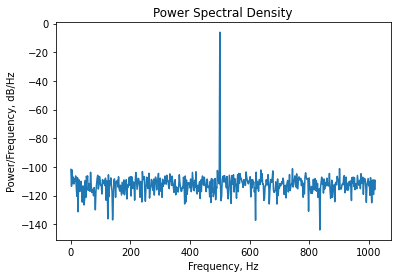

In [16]:
# Set basic params
fs = 2048 # sample rate
f = 500 # frequency of signal
N_fft = 1024 # fft size

# Create complex sine wave, and add a little bit of white gaussian noise
sine = np.sin(2*np.pi*f*np.arange(N_fft)/fs) + 0.0001*np.random.randn(N_fft,)

# Calculate fft and corresponding frequencies
sine_fft = np.fft.fft(sine, N_fft)[:int(N_fft/2)]
freqs = np.fft.fftfreq(N_fft,1/fs)[:int(N_fft/2)]

# convert to dB scale
# since we are using a rectangular window by default, N_fft is equivalent to 
# the sum of window weights
sine_fft_db = 10*np.log10(2*(np.abs(sine_fft)**2)/N_fft/fs)

# plt.plot(freqs[int(N_fft/2):], sine_fft_db[int(N_fft/2):])
plt.plot(freqs, sine_fft_db)
plt.ylabel('Power/Frequency, dB/Hz')
plt.xlabel('Frequency, Hz')
plt.title('Power Spectral Density')
plt.show()

We can roughly estimate the Signal to Noise Ratio (SNR) by subtracting from the power of our signal power value (which is our sine wave) and the average power of the noise floor, which we can estimate by taking the mean of a frequency region where the signal isn't present.

In [17]:
dynamic_range_approximation = np.max(sine_fft_db) - np.mean(sine_fft_db[-200:])
print('SNR = {} dB'.format(dynamic_range_approximation))

SNR = 106.59132869463275 dB


## Waterfall Plots <a class="anchor" id="waterfall"></a>

The power spectrum gives us a lot of insight into sampled signals, and allows us to make many meaningful measurements. However, what if we were also interested in observing the frequency changes over time? A thing you will often encoutner in spectrum analyzers, especially in the context of Software Defined Radio (SDR), is the waterfall plot.

Here we will implement one possible implementation of the Short-time Fourier transform (SFT), which is essentially chopping up the signal of interest into N number of frames, which will then individually be applied a window to and passed to an FFT. Later we can stitch these together into a 2-D image which shows our signal's behaviour over time.

Let's revisit our sum of tones example, but this time with a longer observation window.

In [18]:
# Set basic params
fs = 1024 # sample rate
f1 = 60 # frequency of first signal
f2 = 120 # frequency of 2nd signal
f3 = 250 # frequency of 3rd signal
N_fft = 512 # fft size

L = 512*256 # we want 256 frames of 512 FFT windows

# create a sampled sinusoid and corresponding frequencies for plotting
sine_1 = np.sin(2*np.pi*f1*np.arange(L)/fs)
sine_2 = 0.5*np.sin(2*np.pi*f2*np.arange(L)/fs)
sine_3 = 0.7*np.sin(2*np.pi*f3*np.arange(L)/fs)

sum_of_tones = sine_1 + sine_2 + sine_3

We will reshape our sum of tones signal, so that it contains 256 frames of length 512.

In [19]:
sum_of_tones = sum_of_tones.reshape(-1,512)
sum_of_tones.shape

(256, 512)

The Numpy FFT gets applied to all the frames in our array. Once again, we will only be looking at the positive side of the spectrum.

In [20]:
# Compute FFT and calculate the PSD
fft_result = np.fft.fft(sum_of_tones*np.hamming(N_fft), N_fft)[:,:int(N_fft/2)]
PSD = 10*np.log10(2*np.abs(fft_result)**2/N_fft/fs)

# Get corresponding frequencies, take only positive spectrum
freqs = np.fft.fftfreq(N_fft,1/fs)[:int(N_fft/2)]

Now we can plot the PSD over time. Since we are plotting stationary signals (sine waves) we expect them to be fairly straight and unchanging over time.

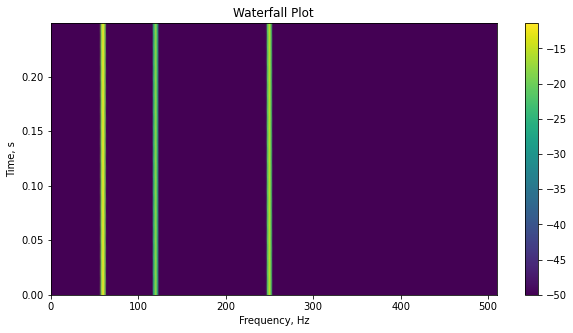

In [21]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
im = plt.pcolormesh(freqs, np.arange(int(L/N_fft))/fs, PSD, vmin=-50, shading='gouraud')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Time, s')
ax.set_title('Waterfall Plot')
fig.colorbar(im)
plt.show()

## Conclusion

In this notebook we covered the fundamentals of converting signals from time domain to frequency domain using the DFT, and its more efficient implementation in the FFT using Numpy libraries. Additionally, we covered some technical tradeoffs one may encounter doing spectral analysis such as FFT size for spectral resolution and windowing being one of the solutions to spectral leakage. To further brush up on how to manipulate signals in the frequency domain, you could go through the [digital filter design material](../digital_filters/01_digital_filter_design.ipynb).

We can use this exact same principles to view individual FM stations, GSM channels, Wi-Fi transmissions or even 4G LTE subcarriers over the air, and many others. This is assuming we have the hardware capable of capturing and sampling at those rates!

----
----